In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from explode import explode
import shapely
from shapely.geometry import mapping
from coord import coord
import matplotlib.pyplot as plt

In [2]:
#SET COUNTRY <----------------------------------------------------------------------------------CHANGE
n = 'ESP' 
#n = '2019_g25_100m_10-20_6m_02-01'
#n = '2019_g25_100m_10-20_1yr_02-01'
#n = '2018_g25_100m_10-20_6m_02-02'
#n = '2018_g25_100m_10-20_1yr_02-02'
#n = 'farm_pts_update'

#SET CRS #<-------------------------------------------------------------------------------------CHANGE
#crs = 'epsg:25830'
#crs = 'epsg:3003' #italy
#crs = 'epsg:2154' #france
crs = 'epsg:2062' #spain

#open file
#f = '../Users/targets_0_sar/greece/'
f = '../targets_0_sar/'
pts = gpd.read_file(f + 'sar_' + n + '.geojson')
#pts = gpd.read_file(f + n + '.shp')

#load search area and exclusion zones
f2 = '/Users/Zack/0_seawarden/'
#search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_greece.shp')
#exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/GRC_exclusions_2020-01-07.geojson')
#farm_sites = gpd.read_file(f2 + 'greece/1_sites/farm_extent_286_edit.shp')

search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_' + n + '.shp')
exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/' + n + '_exclusions.geojson')

#re-project layers
pts = pts.to_crs({'init': crs})
search_area = search_area.to_crs({'init': crs})
exclusion_zones = exclusion_zones.to_crs({'init': crs})

print('detections', len(pts), pts.crs)
print('search area', len(search_area), search_area.crs)
print('exclusion zones', len(exclusion_zones), exclusion_zones.crs)

detections 8424 {'init': 'epsg:2062'}
search area 1 {'init': 'epsg:2062'}
exclusion zones 9 {'init': 'epsg:2062'}


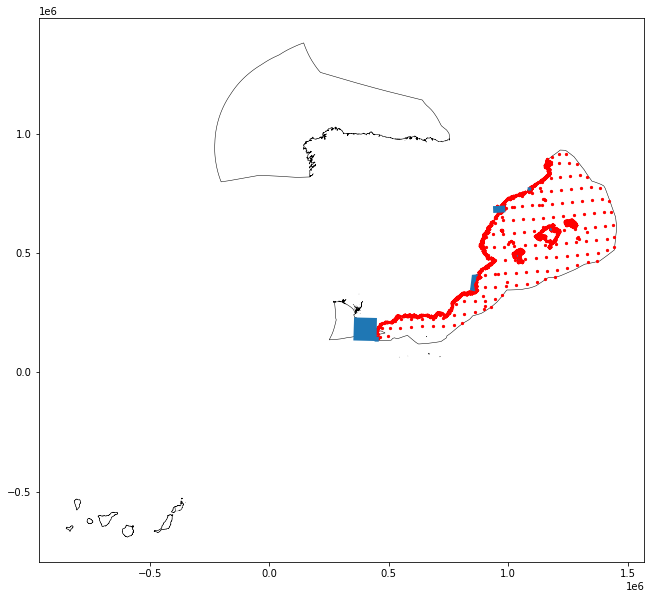

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
pts.plot(markersize=5, facecolor='red', ax=ax)
exclusion_zones.plot(ax=ax)

In [4]:
%%time 
#clip points to search area
clip = sjoin(pts, search_area, how='inner', op='within')
print('detections within search area:', len(clip))

detections within search area: 5115
Wall time: 634 ms


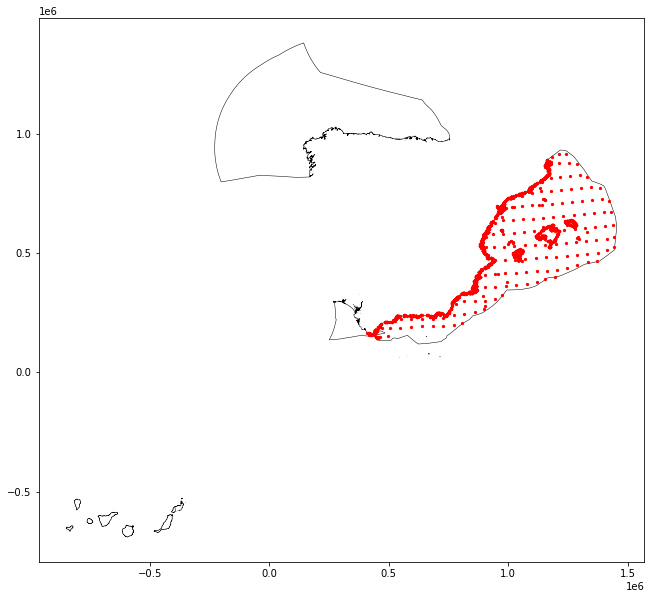

In [5]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
clip.plot(markersize=5, facecolor = 'red', ax=ax)

In [6]:
%%time 
#combine all exclusion zones
exclusion_zones['Dissolve'] = 0
exclusion_zones_dis = exclusion_zones.dissolve(by='Dissolve')

Wall time: 23.7 ms


In [7]:
%%time 
#exclude points in exclusion areas
mask = ~clip.within(exclusion_zones_dis.loc[0, 'geometry'])
clip2 = clip.loc[mask]
print('detections outside of exclusion zones:', len(clip2))

detections outside of exclusion zones: 2665
Wall time: 533 ms


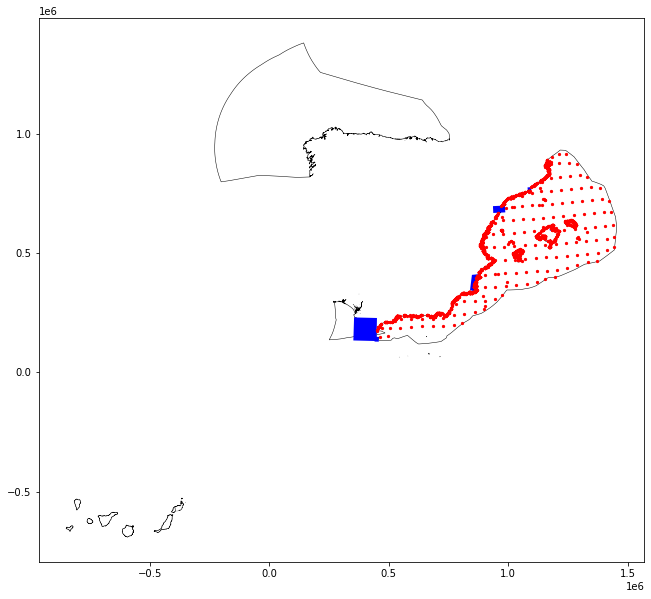

In [8]:
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
exclusion_zones_dis.plot(facecolor = 'blue', ax=ax)
clip2.plot(markersize=5, facecolor = 'red', ax=ax)

In [9]:
%%time 
#buffer points, dissolve buffers to aggregate points near each other
buffer = gpd.GeoDataFrame(geometry = clip2.buffer(10))
buffer['Dissolve'] = 0
buffer_dis = buffer.dissolve(by='Dissolve')

Wall time: 225 ms


In [10]:
%%time 
#explode polygon and generate centroids
buffer_exploded = explode(buffer_dis)      
centroids = gpd.GeoDataFrame(geometry = buffer_exploded.centroid)
#centroids = gpd.GeoDataFrame(geometry = pts.centroid)
print('detections after aggregation:', len(centroids))

detections after aggregation: 2647
Wall time: 915 ms


In [11]:
%%time 
#buffer centroids and make square polygons
centroid_buffer = gpd.GeoDataFrame(geometry = centroids.buffer(500))
envelope = gpd.GeoDataFrame(geometry = centroid_buffer.envelope)

Wall time: 175 ms


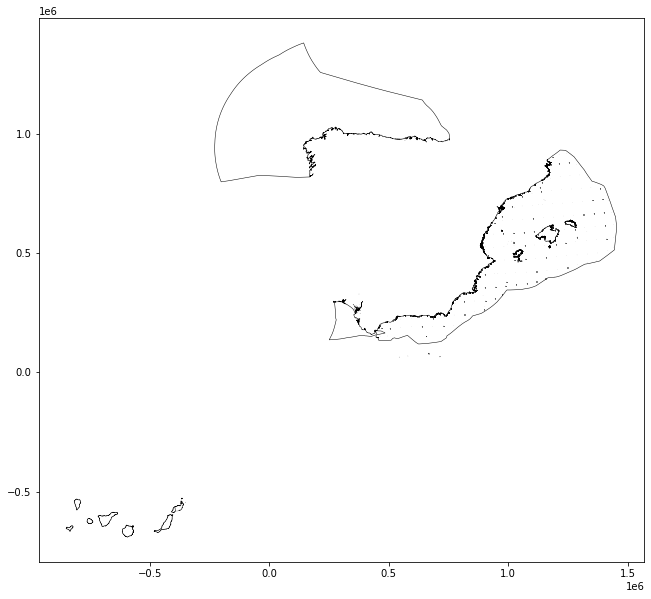

In [12]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
centroid_buffer.plot(markersize=5, facecolor = 'black', ax=ax)
envelope.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

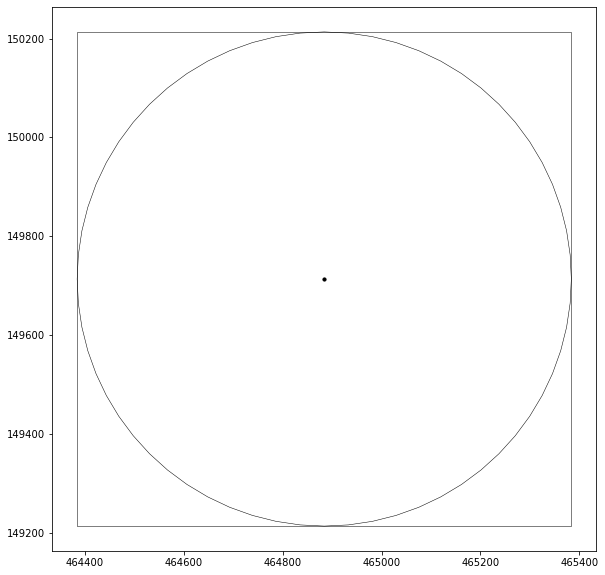

In [13]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = centroids.loc[[0], 'geometry'].plot(markersize=10, facecolor = 'black')
centroid_buffer.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)
envelope.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

In [14]:
#set crs
envelope.crs = {'init' : crs}
envelope['geometry'] = envelope['geometry'].to_crs(epsg=4326)
print(envelope.crs)
envelope.head()

{'init': 'epsg:2062'}


,geometry
0,POLYGON ((-5.188754826367176 35.92689686637807...
1,"POLYGON ((-4.84828224863714 35.95840393042162,..."
2,POLYGON ((-5.360894442467767 36.15102019522206...
3,POLYGON ((-5.339238811362196 36.17518442369619...
4,POLYGON ((-5.337990187125001 36.17584686709026...


In [15]:
#extract lat/long for each square polygon (envelope)
coord_list = []
for i in range(len(envelope)):
    coords = mapping(envelope.geometry[i])['coordinates']
    coord_list.append(coords)

In [16]:
# #combine x/y point groups
coord_all = []
for i in range(len(coord_list)):
    coord_group = coord(coord_list[i]) #function to extract and format x/y points
    coord_group['id'] = i
    coord_all.append(coord_group) 
targets = pd.concat(coord_all)
print('total coordinates (5 per detection):', len(targets))
targets.head()

total coordinates (5 per detection): 13235


,x,y,id
0,-5.188754826367176,35.92689686637807,0
1,-5.177690233419902,35.927047854194875,0
2,-5.177875198330865,35.936047702995396,0
3,-5.188941164521078,35.935896695031275,0
4,-5.188754826367176,35.92689686637807,0


In [17]:
#accuracy check
centroids_test = centroids.copy()
centroids_test.crs = {'init' :crs}
centroids_test['geometry'] = centroids_test['geometry'].to_crs(epsg=4326)

# matches = centroids_test.intersects(farm_sites.unary_union)
# count = centroids_test.loc[matches]

# detections_n = len(centroids_test)
# farm_n = len(farm_sites)
# matches_n = len(count)

# print('total detections:', len(pts))
# print('detections in search area:', detections_n)
# print('farm sites:', farm_n)
# print('matches:', matches_n)
# print('positive matches', round(matches_n / farm_n, 3))
# print('overall accuracy', round(matches_n / detections_n, 3))

# plt.rcParams['figure.figsize'] = (20, 10)
# ax=farm_sites.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
# centroids_test.plot(markersize=1, facecolor = 'red', ax=ax)

In [18]:
pts.to_file(f2 + n + '.shp')
targets.to_csv(f2 + n + '.csv', index = None, header=True)

centroids_test.crs = {'init' :'epsg:4326'}
centroids_test.to_file(f2 + n + '_v2.shp')
centroids_test.to_file(f2 + n + '_v2.geojson', driver='GeoJSON')